In [2]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 5.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


INICIANDO ANALISIS COMPLETO

Primeras 5 filas del dataset:
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  
   -> Procesando fechas, horas y duracio

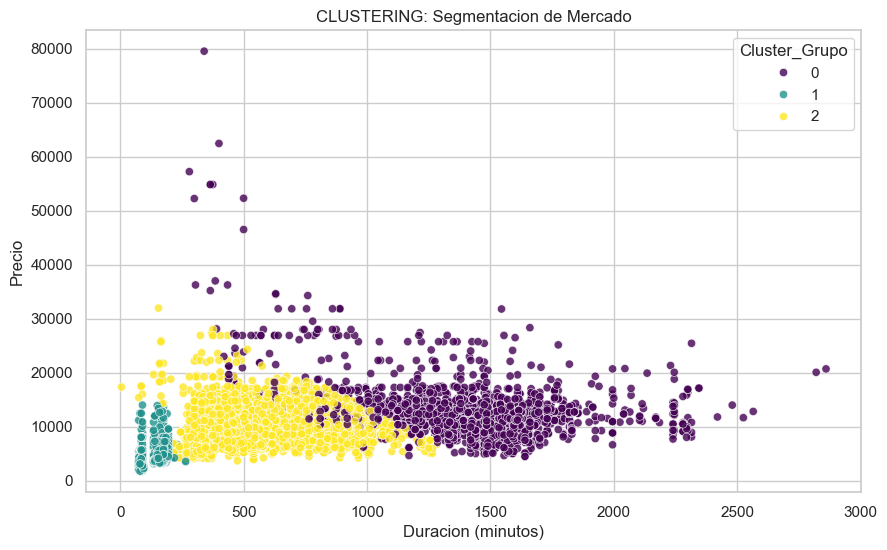


Entrenando IA (Random Forest)...

[2] EVALUACION DE LA REGRESION
----------------------------------------
   R2 Score (Precision Global): 0.7991
   MAE (Error Medio):           1182.55
   MAPE (Error Porcentual):     12.87%


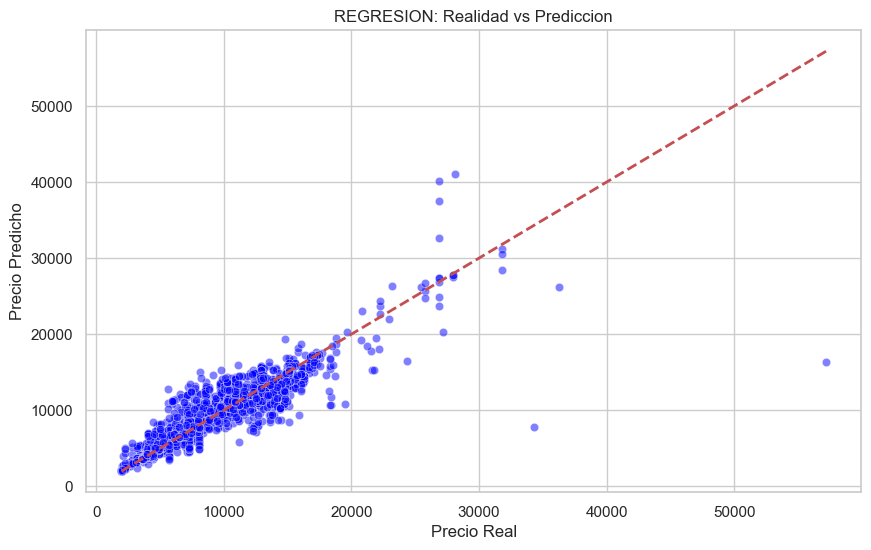


[3] FEATURE IMPORTANCE (Variables mas influyentes)
Duration_Total_Mins    0.487133
Journey_day            0.124141
Airline                0.096991
Total_Stops            0.051932
Journey_month          0.051811
Arrival_hour           0.036512
Dep_hour               0.031801
Journey_weekday        0.030906
dtype: float64

[4] MATRIZ DE CONFUSION (Por Categorias de Precio)


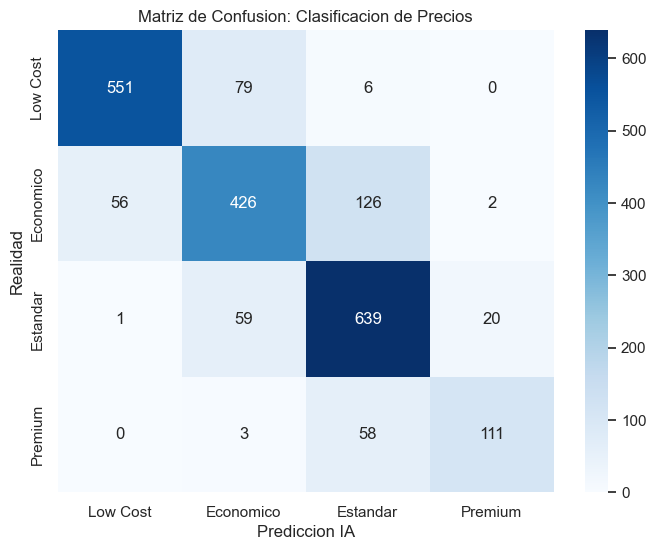

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importamos las herramientas de Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix

# Configuración de visualización
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# 1. Limpieza y procesado

def limpiar_duracion(duration):
    # Esta función estandariza el texto. Convierte "19h" a "19h 0m" para evitar errores al separar
    if len(duration.split()) != 2:
        if "h" in duration:
            duration = duration.strip() + " 0m"
        else:
            duration = "0h " + duration
    return duration

def procesar_datos(df):
    print("   -> Procesando fechas, horas y duraciones...")
    
    # Convertimos la columna a formato fecha real
    fecha_dt = pd.to_datetime(df.Date_of_Journey, format="%d/%m/%Y")

    # 1. Extraemos Día del mes y Mes
    df["Journey_day"] = fecha_dt.dt.day
    df["Journey_month"] = fecha_dt.dt.month
    
    # Extraemos el Día de la Semana
    # Esto genera un número del 0 al 6:
    df["Journey_weekday"] = fecha_dt.dt.dayofweek
    
    # Extraemos horas y minutos
    df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour
    df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute
    df["Arrival_hour"] = pd.to_datetime(df.Arrival_Time).dt.hour
    df["Arrival_min"] = pd.to_datetime(df.Arrival_Time).dt.minute
    
    # Duración
    duration = [limpiar_duracion(x) for x in list(df["Duration"])]
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split(sep = "h")[0]))
        duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))
    
    df["Duration_Total_Mins"] = np.array(duration_hours) * 60 + np.array(duration_mins)

    # Escalas
    df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace=True)
    
    # Limpieza de columnas viejas
    cols_drop = ["Date_of_Journey", "Dep_Time", "Arrival_Time", "Duration", "Additional_Info", "Route"]
    df.drop(cols_drop, axis=1, inplace=True, errors='ignore')
    
    # Encoding
    cols_categ = ['Airline', 'Source', 'Destination']
    for col in cols_categ:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        
    return df

# 2. Visualización y analisis

def ejecutar_clustering(df):
    print("\n[1] EJECUTANDO CLUSTERING (Segmentacion)...")
    
    # Seleccionamos variables clave para agrupar los vuelos
    X_cluster = df[['Price', 'Duration_Total_Mins', 'Total_Stops']]
    
    # Escalamos los datos: KMeans es sensible a la magnitud (Precio es 10.000, Escalas es 1).
    # StandardScaler pone todo en la misma escala para que el Precio no domine el cálculo.
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)
    
    kmeans = KMeans(n_clusters=int(3), random_state=int(42), n_init=int(10))
    df['Cluster_Grupo'] = kmeans.fit_predict(X_scaled)
    
    # Visualización
    plt.figure(figsize=(int(10), int(6)))
    sns.scatterplot(data=df, x='Duration_Total_Mins', y='Price', hue='Cluster_Grupo', palette='viridis', alpha=0.8)
    plt.title('CLUSTERING: Segmentacion de Mercado')
    plt.xlabel('Duracion (minutos)')
    plt.ylabel('Precio')
    plt.show()
    return df

def evaluar_regresion(y_test, y_pred):
    print("\n[2] EVALUACION DE LA REGRESION")
    print("-" * 40)
    
    # Cálculo de métricas de error
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # MAPE: Error porcentual promedio.
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"   R2 Score (Precision Global): {r2:.4f}")
    print(f"   MAE (Error Medio):           {mae:.2f}")
    print(f"   MAPE (Error Porcentual):     {mape:.2f}%")
    
    # Gráfico de dispersión: Realidad vs Predicción
    plt.figure(figsize=(int(10), int(6)))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue')
    
    # Línea de referencia perfecta (diagonal)
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'r--', lw=2)
    
    plt.xlabel('Precio Real')
    plt.ylabel('Precio Predicho')
    plt.title('REGRESION: Realidad vs Prediccion')
    plt.show()

def ver_importancia(model, columns):
    print("\n[3] FEATURE IMPORTANCE (Variables mas influyentes)")
    # Extrae qué tanto pesó cada variable en la decisión del árbol
    importances = pd.Series(model.feature_importances_, index=columns)
    print(importances.nlargest(int(8)))

def matriz_confusion_rangos(y_real, y_pred):
    print("\n[4] MATRIZ DE CONFUSION (Por Categorias de Precio)")
    
    # Convertimos una regresión continua (números) en clasificación (rangos)
    # Esto nos permite ver si el modelo confunde vuelos "Baratos" con "Caros"
    bins = [0, 6000, 10000, 15000, 100000]
    labels = ['Low Cost', 'Economico', 'Estandar', 'Premium']
    
    # pd.cut trocea la variable numérica en los tramos definidos arriba
    y_real_cat = pd.cut(y_real, bins=bins, labels=labels)
    y_pred_cat = pd.cut(y_pred, bins=bins, labels=labels)
    
    cm = confusion_matrix(y_real_cat, y_pred_cat, labels=labels)
    
    plt.figure(figsize=(int(8), int(6)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediccion IA')
    plt.ylabel('Realidad')
    plt.title('Matriz de Confusion: Clasificacion de Precios')
    plt.show()

# 3. Main

def main():
    print("INICIANDO ANALISIS COMPLETO")
    archivo = "Data_Train.xlsx"
    
    try:
        df = pd.read_excel(archivo)
        df.dropna(inplace=True)
        print("\nPrimeras 5 filas del dataset:")
        print(df.head())
    except Exception as e:
        print(f"Error: {e}")
        return

    # A. Procesar
    df_clean = procesar_datos(df)
    
    # B. Clustering
    df_clean = ejecutar_clustering(df_clean)
    
    # C. Preparar Datos Regresión
    print("\nEntrenando IA (Random Forest)...")
    
    # Separamos Features (X) y Target (y).
    # Eliminamos 'Cluster_Grupo' para evitar data leakage (fuga de datos),
    # ya que el cluster se calculó usando el precio.
    X = df_clean.drop(['Price', 'Cluster_Grupo'], axis=1)
    y = df_clean['Price']
    
    # Dividimos en Train (80%) y Test (20%).
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=float(0.2), random_state=int(42)
    )
    
    # Random Forest: Un ensamblaje de múltiples árboles de decisión.
    # Es robusto frente al overfitting y maneja bien relaciones no lineales.
    rf = RandomForestRegressor(n_estimators=int(100), random_state=int(42))
    rf.fit(X_train, y_train)
    
    # Generamos predicciones sobre el conjunto de test (datos que la IA nunca vio)
    y_pred = rf.predict(X_test)
    
    # D. Evaluaciones Finales
    evaluar_regresion(y_test, y_pred)
    ver_importancia(rf, X.columns)
    matriz_confusion_rangos(y_test, y_pred)

if __name__ == "__main__":
    main()